Week 6
Building simple climate models using climlab

https://climlab.readthedocs.io/en/latest/ 


https://brian-rose.github.io/ClimateLaboratoryBook/courseware/climlab-intro.html#using-climlab-to-implement-the-zero-dimensional-energy-balance-model

#!pip install metpy
#!pip install numpy
#!pip install xarray
#!pip install matplotlib

In [ ]:
#!conda install -c conda-forge climlab
import climlab 

In [48]:
#  This code is used just to create the skew-T plot of global, annual mean air temperature
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import xarray as xr
#from metpy.plots import SkewT

Basic of climlab
#Using climlab to implement the zero-dimensional energy balance model

In [49]:
# create a zero-dimensional domain with a single surface temperature
state = climlab.surface_state(num_lat=1,  # a single point
                              water_depth = 100.,  # 100 meters slab of water (sets the heat capacity)
                             )
print(state)  

AttrDict({'Ts': Field([[32.]])})


Here we have created a dictionary called state with a single item called Ts:

In [9]:
print(state['Ts'])

[[32.]]


This dictionary holds the state variables for our model – which is this case is a single number! It is a temperature in degrees Celsius.

In [10]:
print(state.Ts)

[[32.]]


It is also possible to see this state dictionary as an xarray.Dataset object:

In [11]:
climlab.to_xarray(state)

<xarray.Dataset>
Dimensions:       (depth: 1, lat: 1, depth_bounds: 2, lat_bounds: 2)
Coordinates:
  * depth         (depth) float64 50.0
  * lat           (lat) float64 0.0
  * depth_bounds  (depth_bounds) float64 0.0 100.0
  * lat_bounds    (lat_bounds) float64 -90.0 90.0
Data variables:
    Ts            (depth, lat) float64 32.0

Create the subcomponents of the model

In [12]:
delta_t = 60. * 60. * 24. * 30.  # 30 days, or about 1 month!

#  create the longwave radiation process
olr = climlab.radiation.Boltzmann(name='OutgoingLongwave',
                                  state=state, 
                                  tau = 0.612,
                                  eps = 1.,
                                  timestep = delta_t)
#  Look at what we just created
print(olr)

climlab Process of type <class 'climlab.radiation.boltzmann.Boltzmann'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>



In [13]:
#  create the shortwave radiation process
asr = climlab.radiation.SimpleAbsorbedShortwave(name='AbsorbedShortwave',
                                                state=state, 
                                                insolation=341.3, 
                                                albedo=0.299,
                                                timestep = delta_t)
#  Look at what we just created
print(asr)

climlab Process of type <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



Create the model by coupling the subcomponents

In [50]:
#  couple them together into a single model
ebm = climlab.couple([olr,asr])
#  Give the parent process name
ebm.name = 'EnergyBalanceModel'
#  Examine the model object
print(ebm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
EnergyBalanceModel: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>
   AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



The object called ebm here is the entire model – including its current state (the temperature Ts) as well as all the methods needed to integrated forward in time!

The current model state, accessed two ways:

In [52]:
ebm.state

AttrDict({'Ts': Field([[31.61786227]])})

In [53]:
ebm.Ts

Field([[31.61786227]])

Take a single timestep forward

In [54]:
print(ebm.time['timestep'])
print(ebm.time['steps'])

2592000.0
0


This says the timestep is 2592000 seconds (30 days!), and the model has taken 0 steps forward so far.

To take a single step forward:

In [55]:
ebm.step_forward()

In [56]:
ebm.Ts

Field([[31.24505044]])

The model got colder!

In [57]:
ebm.diagnostics

{'OLR': Field([[299.39165867]]), 'ASR': 239.25130000000004}

In [21]:
ebm.OLR

Field([[300.896072]])

In [22]:
ebm.ASR

239.25130000000004

So why did the model get colder in the first timestep?

What do you think will happen next?

Run the zero-dimensional EBM out to equilibrium

In [58]:
for name, process in ebm.subprocess.items():
    print(name)
    print(process)

OutgoingLongwave
climlab Process of type <class 'climlab.radiation.boltzmann.Boltzmann'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>

AbsorbedShortwave
climlab Process of type <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



The parameter tau is a property of the OutgoingLongwave subprocess:

In [59]:
ebm.subprocess['OutgoingLongwave'].tau

0.612

and the parameter albedo is a property of the AbsorbedShortwave subprocess:

In [25]:
ebm.subprocess['AbsorbedShortwave'].albedo

0.299

Let’s make an exact clone of our model and then change these two parameters:

In [26]:
ebm2 = climlab.process_like(ebm)
print(ebm2)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
EnergyBalanceModel: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>
   AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



In [60]:
ebm2.subprocess['OutgoingLongwave'].tau = 0.57
ebm2.subprocess['AbsorbedShortwave'].albedo = 0.32

In [61]:
#  Computes diagnostics based on current state but does not change the state
ebm2.compute_diagnostics()
ebm2.ASR - ebm2.OLR

Field([[-45.70181282]])

In [62]:
ebm2.Ts

Field([[31.32798841]])

In [63]:
ebm2.step_forward()

In [64]:
ebm2.Ts

Field([[31.04468154]])

Exercise
Using a for loop, take 500 steps forward with this model

Store the current temperature at each step in an array


Make a graph of the temperature as a function of time

Automatic timestepping

In [32]:
ebm3 = climlab.process_like(ebm2)

In [33]:
ebm3.integrate_years(50)

Integrating for 608 steps, 18262.11 days, or 50 years.
Total elapsed time is 50.10373938170343 years.


Integrating for 608 steps, 18262.11 days, or 50 years.
Total elapsed time is 50.10373938170343 years.

In [34]:
#  What is the current temperature?
ebm3.Ts

Field([[17.94837835]])

In [35]:
#  How close are we to energy balance?
ebm3.ASR - ebm3.OLR

Field([[-0.00021699]])

In [36]:
#  We should be able to accomplish the exact same thing with explicit timestepping
#  And we could make a time-dependent plot too!
ebm4 = climlab.process_like(ebm2)

num_steps = 608
Tarray = np.zeros(num_steps)

for n in range(num_steps):
    ebm4.step_forward()
    Tarray[n] = ebm4.Ts

In [37]:
ebm4.Ts

Field([[17.94837835]])

In [38]:
ebm4.ASR - ebm4.OLR

Field([[-0.00021699]])

Text(0, 0.5, 'Surface temperature (ºC)')

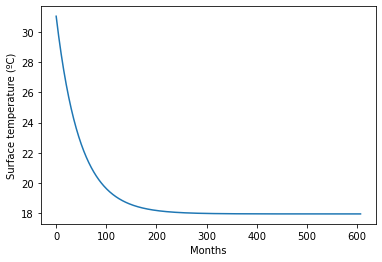

In [39]:
plt.plot(Tarray)
plt.xlabel('Months')
plt.ylabel('Surface temperature (ºC)')

Part II

Advance of climlab

In [40]:
## The NOAA ESRL server is shutdown! January 2019
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", use_cftime=True)

ncep_air

<xarray.Dataset>
Dimensions:             (level: 17, lon: 144, time: 12, lat: 73, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) object ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:                          monthly ltm air from the NCEP Reanalysis
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...

In [41]:
#  Take global, annual average and convert to Kelvin
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
Tglobal

<xarray.DataArray (level: 17)>
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0

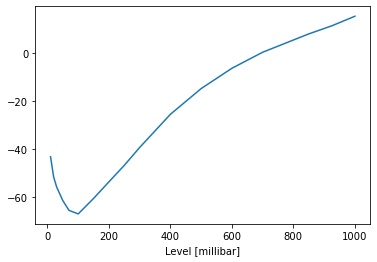

In [42]:
Tglobal.plot()

In [43]:
from metpy.plots import SkewT

Text(0.5, 1.0, 'Global, annual mean sounding from NCEP Reanalysis')

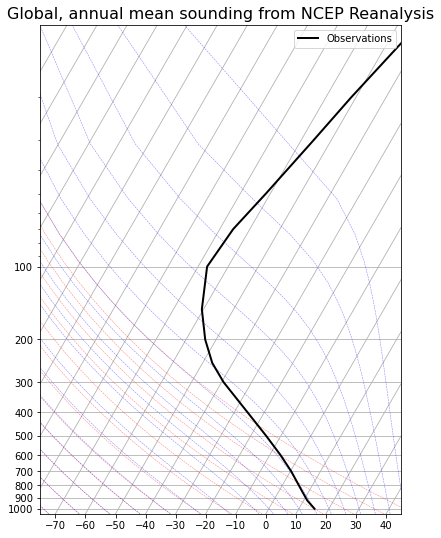

In [44]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)
skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
skew.ax.set_ylim(1050, 10)
skew.ax.set_xlim(-75, 45)
# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.5)
skew.plot_moist_adiabats(linewidth=0.5)
#skew.plot_mixing_lines()
skew.ax.legend()
skew.ax.set_title('Global, annual mean sounding from NCEP Reanalysis', 
             fontsize = 16)

In [45]:
#  This code is used just to create the skew-T plot of global, annual mean air temperature
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", use_cftime=True)
#  Take global, annual average 
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

In [46]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

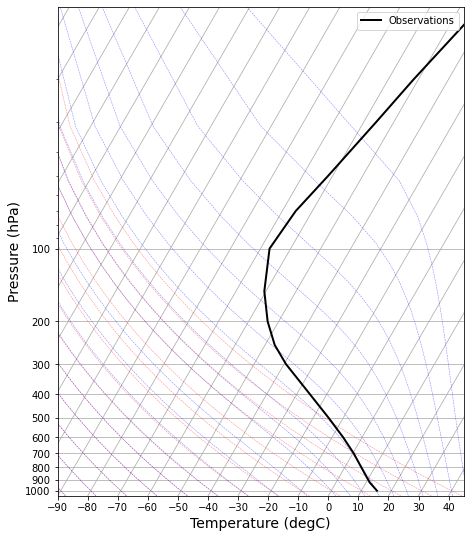

In [47]:
skew = make_skewT()